In [1]:
import os
import numpy as np
from scipy import integrate
import sys
sys.path.append('../../scripts/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24, colors = 'banskt')

In [2]:
# simdir = '15158_450_20_800_30_150_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_20_0.02'
# simdir = '15611_250_20_800_30_150_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_10_0.02'
simdir = '16151_300_20_800_30_150_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_20_0.02'
srcdir = '/scratch/sbanerj/trans-eqtl/simulation'

In [3]:
sbetalist = ['0.1', '0.05', '0.02', '0.01', '0.005']
#sbetalist = ['0.01', '0.05', '0.1', '0.5']
#sbetalist = ['0.05']

auclist = list()
roclist = [x for x in sbetalist]
for i, sbeta in enumerate(sbetalist):
    roc = roclist[i]
    outfile = os.path.join(srcdir, simdir, 'rocdata/rr_sb{:s}_fpr_tpr.txt'.format(sbeta))
    roc = np.loadtxt(outfile, skiprows=1)
    roclist[i] = roc
    auc = integrate.simps(roc[:, 1], roc[:, 0])
    auclist.append(auc)

In [4]:
def zoomplot(ax, xx, yy, label, zoom = 1, yerr = None, color = None):
    nx = len(xx)
    nplot = int(nx * zoom)
    p = ax.plot(xx[:nplot], yy[:nplot], label = label, color = color)
    return p[0].get_color()
    
def add_vert(fig, ax, hfrac, vfrac, hoffset, voffset):

    bbox = ax.get_position()
    axleft = bbox.x0
    axwidth = bbox.width
    axbottom = bbox.y0
    axheight = bbox.height

    iax_left   = axleft   + hoffset * axwidth
    iax_bottom = axbottom + voffset * axheight
    iax_width  = hfrac * axwidth
    iax_height = vfrac * axheight

    iax = fig.add_axes([iax_left, iax_bottom, iax_width, iax_height])
    return iax

def single_barplot(ax, yvals, ymax, yerr, methodcolors, ymajorticks, yminorticks, yshift,
                   xlabel, ylabel, xticklabels, showyaxis, showxlabel, showerror):
    
    nbar = len(yvals)

    ax.set_yticks([y - yshift for y in ymajorticks])
    ax.set_yticks([y - yshift for y in yminorticks], minor=True)
    ax.set_xticks(list(range(1, nbar + 1)))
    ax.set_xticklabels(xticklabels)
    ax.tick_params(bottom = True, top = False, left = False, right = False, labelleft = False, labelbottom = True)
    ax.grid(which = 'minor', axis = 'y', linestyle = 'dotted', zorder = 0)
    
    ind = np.arange(1, nbar + 1)
    ax.bar(ind, [y - yshift for y in yvals], color = methodcolors, linewidth = 0, width = 0.8, zorder = 10)
    
    # Errorbars done separately. The one included in bar() method mess up the zorder
    if showerror:
        for i in range(nbar):
            errmin = yvals[i] - yerr[i] - yshift
            errmax = yvals[i] + yerr[i] - yshift
            ax.plot([ind[i], ind[i]], [errmin, errmax], color = '#333333', zorder = 20)

    
    if showyaxis: 
        ax.tick_params(which = 'major', left = True, labelleft = True)
        yticks = ax.get_yticks(minor = False)
        yticklabels = ['{:2.1f}'.format(y + yshift) for y in yticks]
        ax.set_yticklabels(yticklabels, minor = False)
        ax.set_ylabel(ylabel, labelpad = 5)
        ax.yaxis.set_label_position("left")
        
    if showxlabel:
        ax.set_xlabel(xlabel, labelpad = 5)
        
    for side, border in ax.spines.items():
        if not side == 'bottom':
            border.set_visible(False)
        if showyaxis and side == 'left':
            border.set_visible(True)

    ax.set_ylim([-0.01, ymax - yshift])
    ax.set_xlim([0, nbar + 1])
    ax.set_facecolor('None')
    
def horizontal_barplot(ax, values, methodcolors, yticklabels, xmajorticks, xgrids, 
                       ylabel, xlabel, xshift = 0.5):
    nbar = len(values)
    ind = np.arange(1, nbar + 1)
    shifted_values = [x - xshift for x in values]
    ax.barh(ind, shifted_values, color = methodcolors, linewidth = 0, height = 0.2, zorder = 10)
    
    ax.tick_params(bottom = False, top = False, left = False, right = False, 
                   labelleft = True, labelbottom = False, labeltop = False)
    ax.set_yticks(list(range(1, nbar + 1)))
    ax.set_yticklabels(yticklabels)
    
    ax.tick_params(bottom = True, labelbottom = True)
    ax.set_xticks([x - xshift for x in xmajorticks])
    ax.set_xticks([x - xshift for x in xgrids], minor = True)
    xticklabels = ['{:2.1f}'.format(x) for x in xmajorticks]
    ax.set_xticklabels(xticklabels)
    #ax.grid(which = 'minor', axis = 'x', linestyle = 'dotted', zorder = 0)
    
    for side, border in ax.spines.items():
        border.set_visible(False)
        if side == 'bottom':
            border.set_visible(True)

    ax.xaxis.set_label_position('top')
    #ax.set_ylabel(ylabel, rotation = 0, labelpad = 10, y = 1.1)
    ax.set_xlabel(xlabel, x = 0.4)
    ax.set_ylim([0, nbar + 0.5])

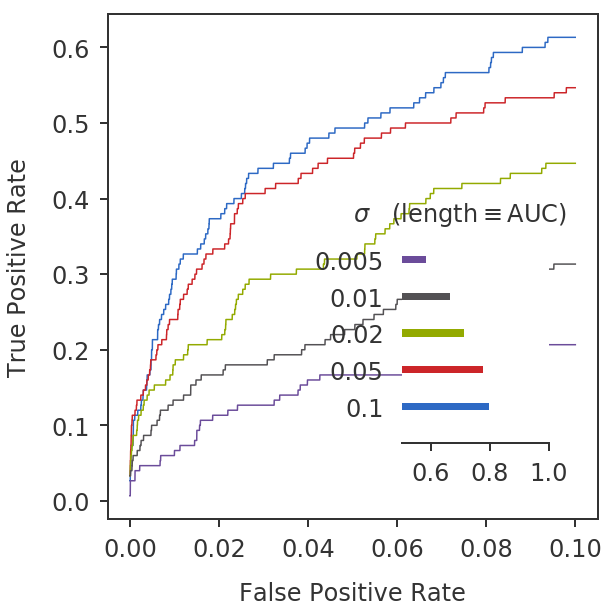

In [7]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)#, aspect='equal')

mcolors = list()
for i, sbeta in enumerate(sbetalist):
    roc = roclist[i]
    color = zoomplot(ax1, roc[:, 0], roc[:, 1], sbeta, zoom = 0.1, yerr = roc[:, 2])
    mcolors.append(color)

plt.tight_layout()
# ax1.legend()

# Inset of AUC
iax = add_vert(fig, ax1, 0.3, 0.4, 0.6, 0.15)
ymax = 1.0
yshift = 0.5
xmajorticks = [0.6, 0.8, 1.0]
xminorticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
yerr = [0 for x in sbetalist]
showyaxis = True
showxlabel = True
showerror = False
yticklabels = sbetalist

horizontal_barplot(iax, auclist, mcolors, yticklabels, xmajorticks, xminorticks,
                   "", "${\sigma}\quad$(length$\equiv$AUC)")


ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
# plt.savefig('../plots/sigbeta_450sample_150tf_mean04_gtex_ms_correlation.png', bbox_inches='tight')
plt.show()